### Cab-Driver Agent

Approach : Inputting state only as the input to the DL model (Arch 1)

In [ ]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import time

# # for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
path = '/content/drive/MyDrive/UPGRAD/RL_Project202107CabDriverProfitOptmization/20210717_615pm'

#### Defining Time Matrix

In [ ]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

In [ ]:
Time_matrix.shape

(5, 5, 24, 7)

In [ ]:
Time_matrix[2][1][12][2]

1.0

In [ ]:
Time_matrix.shape

(5, 5, 24, 7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


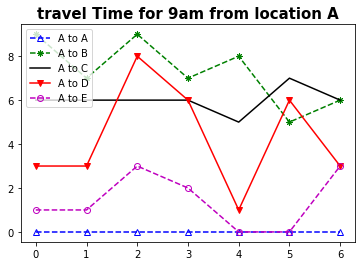

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X_axis = [x for x in range(7)]
t = [Time_matrix[x][0][8] for x in range(0,5)]
 
fig=plt.figure()
plt.title("travel Time for 9am from location A", fontsize=15, fontweight='bold')
ax=fig.add_subplot(111)
 
ax.plot(X_axis,t[0],c='b',marker="^",ls='--',label='A to A',fillstyle='none')
ax.plot(X_axis,t[1],c='g',marker=(8,2,0),ls='--',label='A to B')
ax.plot(X_axis,t[2],c='k',ls='-',label='A to C')
ax.plot(X_axis,t[3],c='r',marker="v",ls='-',label='A to D')
ax.plot(X_axis,t[4],c='m',marker="o",ls='--',label='A to E',fillstyle='none')
# ax.plot(X_axis,x-1,c='k',marker="+",ls=':',label='DGYC')
 
plt.legend(loc=2)
plt.show()

REf: https://stackoverflow.com/questions/23582489/python-pickle-protocol-choice

#### Tracking the state-action pairs for checking convergence


In [ ]:
import collections
states_track = collections.defaultdict(dict)
def initialise_tracking_states():
    sample_q_values = [((3,0,2),[(3,1),(0,2),(1,4)]),((1,6,3),[(2,3)]),((2,2,2),[(3,2)]),((1,10,6),[(3,4)]),((0,20,3),[(1,4)]),((1,23,3),[(1,4)]),((4,17,1),[(1,2)])]    #select any 4 Q-values
    for q_values in sample_q_values:
        state = q_values[0]
        for i in q_values[1]:
            action = i
            states_track[state][action] = []    #this is an array which will have appended values of that state-action pair for every 2000th episode         

Note to self : 
usually, a Python dictionary throws a KeyError if you try to get an item with a key that is not currently in the dictionary. The defaultdict in contrast will simply create any items that you try to access (provided of course they do not exist yet). To create such a "default" item, it calls the function object that you pass to the constructor (more precisely, it's an arbitrary "callable" object, which includes function and type objects). For the first example, default items are created using int(), which will return the integer object 0. For the second example, default items are created using list(), which returns a new empty list object.

In [ ]:
initialise_tracking_states() # initialised all the state-action pairs tracked

In [ ]:
print(states_track)

defaultdict(<class 'dict'>, {(3, 0, 2): {(3, 1): [], (0, 2): [], (1, 4): []}, (1, 6, 3): {(2, 3): []}, (2, 2, 2): {(3, 2): []}, (1, 10, 6): {(3, 4): []}, (0, 20, 3): {(1, 4): []}, (1, 23, 3): {(1, 4): []}, (4, 17, 1): {(1, 2): []}})


In [ ]:
# This function will append latest Q-values of the 6 Q-values which are being tracked for checking convergence

def save_tracking_states():
    for state in states_track.keys():
        for action in states_track[state].keys():
            state_encod = env.state_encod_arch(state)
            state_encod = np.reshape(state_encod, [1, agent.state_size])
            prediction = agent.model.predict(state_encod)
            action_list = list(action)
            #print("Action", action_list)
            action_index = env.action_space.index(action_list)
            #print("Action index", action_index)
            Q = prediction[0][action_index]
            #print("Q", Q)
            states_track[state][action].append(Q)          

In [ ]:
#Defining a function to save the object as a pickle file
def save_obj(obj, name ):
    with open(path + '/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

#### Writing the Agent Class : CabDriver()

###### Including Checkpointing ( as the model is taking too long to train)

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size,path):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = 0.95
        self.learning_rate =  0.001 
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.005
        self.epsilon_min = 0.00000001
        
        self.batch_size = 500
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and Load weights from previously stored model
        self.model = self.build_model()

        # self.path = path
        # self.model_loaded_weights  = self.model.load_weights(self.path+"/cab_driver_model_weights.h5")

    # approximate Q function using Neural Network
    
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets
        model.add(Dense(32,activation='relu',input_dim= self.state_size, kernel_initializer='he_uniform'))
        model.add(Dense(32,activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size,activation='linear', kernel_initializer='he_uniform'))
        
        model.compile(loss='mse',optimizer=Adam(learning_rate =self.learning_rate))
        
        # model.summary
        
        return model


    def get_action(self, state, episode):

        # Write your code here:
        possible_actions_index , possible_actions = env.requests(state)
        # get action from model using epsilon-greedy policy
        epsilon = self.epsilon_min + (self.epsilon_max - self.epsilon_min) * np.exp(-self.epsilon_decay*episode)  ##Based on the given epsilon-decay example
            
        z = np.random.random()  ##Takes random value [0,1)
        
        if z > epsilon:
            # model.predict(state)
            state_E = env.state_encod_arch(state)
            state_encoded = np.reshape(state_E,(1,self.state_size))
            q_value = self.model.predict(state_encoded)  ###  check shape of predict output
           
            q_values_possible_actions = q_value[0][possible_actions_index] 

            best_action_index = np.argmax(q_values_possible_actions)
            action = possible_actions[best_action_index]
            # best action - from possible actions   
        else:
            #randomly select the actions 
            index_action = np.random.choice(possible_actions_index)
            action = env.action_space[index_action]
        
        return action, epsilon
       
    
    

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
    
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample batch from the memory
        mini_batch = random.sample(self.memory, self.batch_size)
        ### [(s,a,r,s'),(s,a,r,s') .... ]
        update_output = np.zeros((self.batch_size,self.state_size))# write here
        update_input = np.zeros((self.batch_size,self.state_size))# write here
        actions, rewards, terminal_states = [], [], []
            
        for i in range(self.batch_size):
            state, action, reward, next_state, terminal_bool  = mini_batch[i]
            # state_next = env.next_state_func(state, action, Time_matrix)
            actions.append(action)
            rewards.append(reward)
            terminal_states.append(terminal_bool)
            # Write your code from here
            # 1.  Update your 'update_output' and 'update_input' batch
            update_input[i] = env.state_encod_arch(state)  ############# Change funcition name to arch at the end no numerical subscript to avoid confusion between state and state-action input ( this code is following state only input) ############
            update_output[i] = env.state_encod_arch(next_state)
        
        target = self.model.predict(update_input)
        q_vals_next_state = self.model.predict(update_output) ## (batchsize,len(action_space))
            
        # Check for terminal state before updating the q-value
        for i in range(self.batch_size):
            action_index = env.action_space.index(actions[i])
            if terminal_states[i]:
                target[i][action_index] = rewards[i]
                
            else:
                target[i][action_index] = rewards[i] + self.discount_factor * (np.amax(q_vals_next_state[i]))
        
        # 4. Fit your model and track the loss values
        self.model.fit(update_input, target, batch_size = self.batch_size, verbose = 0, epochs = 1)
                
             
    def save(self, name):
        self.model.save(name)
        print("saved Model")

    def load_model_weights(self, name):
        self.model.load_weights(name)
        
    # def load_model(name):
    #     self.model.load(name)
    
    def save_model_weights(self,name): 
        self.model.save_weights(name)
        print("saved Model weights")

### DQN block

agent = DQNagent(...)
for episode in range(Episodes):

    
    # Write code here
    # Call the environment
    # Call all the initialised variables of the environment
    #Call the DQN agent
    count=0
    while != terminal_state:
        count+=1
        action = agent.get_action(state,episode)
        reward = env.reward_func(state,action,time_matrix)
        next_state,terminal_state = env.next_state_func(state,action,time_matrix)
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        # 2. Evaluate your reward and next state
        # 3. Append the experience to the memory
        if count%20 == 0:
            # 4. Train the model by calling function agent.train_model
            # 5. Keep a track of rewards, Q-values, loss
            agent.train_model()
    if episode% ==:
        agent.save('')

Call the environment

In [ ]:
env = CabDriver()

Call all the initialised variables of the environment

In [ ]:
total_time = env.max_time
Total_Episodes = 1000
m =5
t= 24
d= 7

Testing Next_state_func

Call the DQN agent

In [ ]:
action_size = len(env.action_space)
state_size = m+t+d
agent = DQNAgent(state_size = state_size, action_size=action_size, path=path)

In [ ]:
# tracking average reward per episode = total rewards in an episode/ total steps in an episode
avg_reward = []

# tracking total rewards per episode
total_reward  = []

episode: 0   score: -632.0   memory length: 421   epsilon: 1.0
saved Model
saved Model weights
saved Model weights
episode: 25   score: -54.0   memory length: 2000   epsilon: 0.8824969037596264
episode: 50   score: -92.0   memory length: 2000   epsilon: 0.778800785283397
episode: 75   score: 38.0   memory length: 2000   epsilon: 0.6872892819180795
episode: 100   score: 578.0   memory length: 2000   epsilon: 0.6065306636473269
episode: 125   score: 448.0   memory length: 2000   epsilon: 0.535261433166376
episode: 150   score: 330.0   memory length: 2000   epsilon: 0.4723665580173491
episode: 175   score: 450.0   memory length: 2000   epsilon: 0.41686202550988816
episode: 200   score: 497.0   memory length: 2000   epsilon: 0.3678794474926479


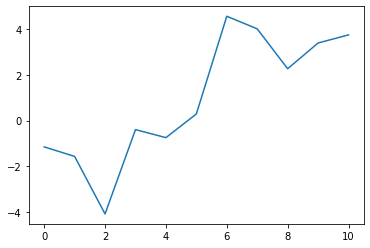

episode: 225   score: 664.0   memory length: 2000   epsilon: 0.324652474111825
episode: 250   score: 668.0   memory length: 2000   epsilon: 0.2865048039951421
saved Model
saved Model weights
saved Model weights
episode: 275   score: 553.0   memory length: 2000   epsilon: 0.25283960327635047
episode: 300   score: 663.0   memory length: 2000   epsilon: 0.2231301679171282
episode: 325   score: 622.0   memory length: 2000   epsilon: 0.1969116832350773
episode: 350   score: 327.0   memory length: 2000   epsilon: 0.17377395171270568
episode: 375   score: 430.0   memory length: 2000   epsilon: 0.1533549753113788
episode: 400   score: 270.0   memory length: 2000   epsilon: 0.13533529188325985


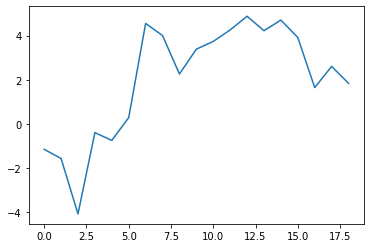

episode: 425   score: 725.0   memory length: 2000   epsilon: 0.11943297707238992
episode: 450   score: 589.0   memory length: 2000   epsilon: 0.10539923350787207
episode: 475   score: 223.0   memory length: 2000   epsilon: 0.0930144982805186
episode: 500   score: 585.0   memory length: 2000   epsilon: 0.08208500780304881
saved Model
saved Model weights
saved Model weights
episode: 525   score: 361.0   memory length: 2000   epsilon: 0.07243976630985388
episode: 550   score: 1230.0   memory length: 2000   epsilon: 0.06392787056742895
episode: 575   score: 911.0   memory length: 2000   epsilon: 0.056416148939615954


In [ ]:

Episodes = 1000
for episode in range(0,Episodes):
    
    # tracking total rewards, step count
    tot_reward = 0
    step_count = 0
    state = env.reset()
    terminal_state = False
    
    while not terminal_state:
        
        action, epsilon = agent.get_action(state, episode)
        reward = env.reward_func(state, action, Time_matrix)
        
        next_state, terminal_state = env.next_state_func(state, action, Time_matrix)

        # save the sample <s, a, r, s'> to the replay memory
        agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # every time step do the training
        agent.train_model()
        tot_reward += reward
        state = next_state
        step_count += 1
        
        # Store the rewards
        if terminal_state and episode % 25 ==0:
            avg_reward.append(tot_reward/step_count)
            total_reward.append(tot_reward)
            print("episode:", episode, "  score:", tot_reward, "  memory length:",
                      len(agent.memory), "  epsilon:", epsilon)
    
    if episode % 250 == 0:
        t_stamp = time.strftime("%Y-%m-%d_%H:%M:%S")
        agent.save(path+"/cab_driver{}.h5".format(t_stamp))
        # agent.save_model_weights(path+"/cab_driver_model_weights{}.h5".format(t_stamp))
        # agent.save_model_weights(path+"/cab_driver_model_weights.h5")

    if episode % 25 == 0:   #every 2000th episode
        # t_stamp = time.strftime("%Y-%m-%d_%H:%M:%S")
        save_obj(avg_reward, 'Rewards')  
        save_tracking_states()
        save_obj(states_track,'States_tracked')  
        
    
    if episode % 200 == 0 and episode !=0:
        plt.plot(list(range(len(avg_reward))), avg_reward)
        plt.show()
        


Observations: episode: 200   score: 441.0   memory length: 2000   epsilon: 0.3678794474926479 



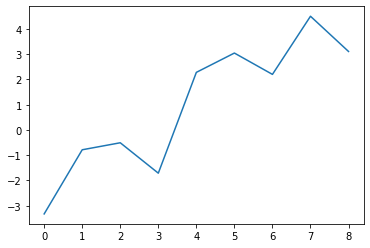

episode: 400   score: 951.0   memory length: 2000   epsilon: 0.13533529188325985


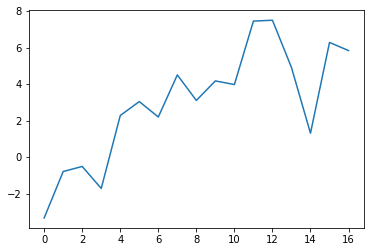

episode: 600   score: 1321.0   memory length: 2000   epsilon: 0.04978707786999326

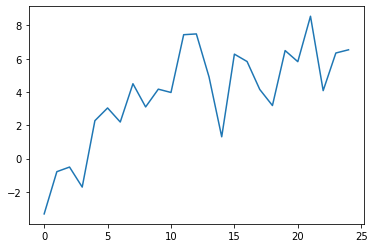

episode: 800   score: 1414.0   memory length: 2000   epsilon: 0.01831564870557779

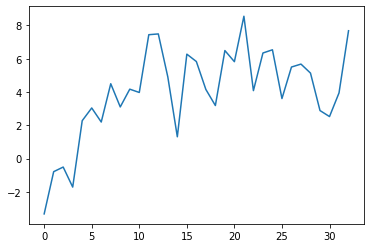

### Tracking Convergence

In [ ]:
# Plotting average rewards
# x-values = 1000 episodes , tracked after every 25th episode
plt.plot(list(range(len(avg_reward))), avg_reward)
plt.ylabel("Average Reward")
plt.show()

In [ ]:
## Write the code for plotting the graphs for state-action pairs tracked

plt.figure(0, figsize=(15,20))
plot_number =321

for i in list(States_track.keys())[:5]:
    for x in list(i.keys())[:5]:
        s = i
        a = x
        s_aPair = (States_track[s][a])
        # print(s)
        # print(a)
        # print(s_aPair)
        x_axis = np.asarray(range(0, len(s_aPair)))
        plt.subplot(plot_number)
        plt.plot(x_axis,np.asarray(s_aPair))
        title = "Convergence plot for: {0},{1}".format(s,str(a))
        plt.title(title, fontsize=15, fontweight='bold')
        plt.ylabel("Q_values", fontsize=13, fontstyle='italic')
        plt.xlabel("No. of Episodes  (step increment of threshold value)", fontsize=13, fontstyle='italic')
        plot_number +=1
        plt.grid(True)
        plt.show



#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [ ]:
time = np.arange(0,100)
epsilon = []
for i in range(0,100):
    epsilon.append(0 + (1 - 0) * np.exp(-0.005*i))

In [ ]:
plt.plot(time, epsilon)
plt.show()

In [ ]:
z:0-1
e:0
e>z